# Load and Plot EMNIST Letters Data

Michael Madden, Feb 2026. 

This loads a file callsed emnist_letters_train.npz" with letters data, already transposed and scaled.

Note that the images as displayed are quite fuzzy looking, because they are low res (28x28).

The labels from 1 to 26, where 1=A and 26=Z. Cases include mix of uppercase and lowercase with the same label.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load("emnist_letters_85800.npz")

x_data = data["x"]
y_data = data["y"]

In [3]:
# Extract just two classes from the dataset

# PUT YOUR OWN CLASS NUMBERS HERE: remember that A=1, z=26.
c1 = 8   # example
c2 = 11  # example

mask = (y_data == c1) | (y_data == c2)

x_binary = x_data[mask]
y_binary = y_data[mask]

# Now change labels to 0 and 1
y_binary = (y_binary == c2).astype(int)

In [4]:
#flattening images 
m = x_binary.shape[0]
X = x_binary.reshape(m,-1)
y = y_binary.reshape(-1,1)
print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: (6600, 784)
y shape: (6600, 1)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)


In [6]:
class LogisticRegressor:
    def __init__(self, alpha=0.01, max_iters=100000, threshold=1e-6, N=1000,hidden_layers=[5, 3, 2], seed=42,lam=0.001):
        self.alpha = alpha
        self.max_iters = max_iters
        self.threshold = threshold
        self.N = N
        self.hidden_layers = hidden_layers
        self.seed = seed
        self.loss_history = []
        self.accuracy_history = []
        self.lam = lam
        self.trained = False #to be used in predict
        


    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))

    #def relu(self, z):
        #return np.maximum(0, z)

    #def relu_derivative(self, z):
        #return (z > 0).astype(float)
    
    def loss_function(self, y, y_cap):
        epsilon = np.finfo(float).eps
        y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
        return -(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
    
    def fit(self, X, Y):
        np.random.seed(self.seed)
        self.loss_history = []
        self.accuracy_history = []

        m = X.shape[0] # samples
        n = X.shape[1] # features

        weights = []
        biases = []

        self.layers = [n] + self.hidden_layers + [1]

        for i in range(len(self.layers) - 1):
            w = np.random.randn(self.layers[i+1], self.layers[i]) * 0.01
            b = np.zeros((self.layers[i+1], 1))
            weights.append(w)
            biases.append(b)

        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1)


        stopping = False; loss_prev = 0; iteration = 0; acc = 0
        

        while not stopping:
            #select random data point
            
            i = np.random.choice(np.arange(m))  # pick a random index
            x = X[i].reshape(-1,1)
            y = Y[i, 0]


            #activations
            a = x
            A = [a]

            #forward pass
            for i in range(len(weights)):
                a = self.sigmoid(weights[i] @ a + biases[i])
                A.append(a)

            y_cap = A[-1] # last activation is the output, hopefully 
            
            loss = self.loss_function(y, y_cap)
            l2_penalty = 0.0
            for w in weights:
                l2_penalty += np.sum(w**2)

            loss = loss + (self.lam / 2.0) * l2_penalty
            self.loss_history.append(float(loss.item()) )
            
            #-----back propagation-----
            deltaw = [np.zeros_like(w) for w in weights]
            deltab = [np.zeros_like(b) for b in biases]


            #output layer
            deltaz = y_cap - y
            deltab[-1] = deltaz
            deltaw[-1] = deltaz @ A[-2].T


            for i in reversed(range(len(weights)-1) ):
                deltaz = (weights[i+1].T @ deltaz) * (A[i+1] * (1 - A[i+1]))
                deltaw[i] = deltaz @ A[i].T
                deltab[i] = deltaz


            #update weights and biases
            for i in range(len(weights)):
                weights[i] -= self.alpha * (deltaw[i] + self.lam * weights[i])
                biases[i] -= self.alpha * deltab[i]

            #to store accuracy per iteration
            pred_i = 1 if y_cap >= 0.5 else 0
            self.accuracy_history.append(1.0 if pred_i == y else 0.0)

        
            loss_prev = loss
            iteration += 1
            if iteration >= self.max_iters:
                stopping = True

        #set weights here
        self.weights = weights
        self.biases = biases
        self.trained = True

    def predict(self,x):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")
        
        #change here
        a = x.T
        for w, b in zip(self.weights, self.biases):
            a = self.sigmoid(w @ a + b)
        Y_pred = (a >= 0.5).astype(int).flatten()
        return Y_pred
    
    def score(self, x_test, y_test):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")        
        
        y_pred = self.predict(x_test)
        #running into shape issues so trying this 
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        correct = 0
        size = len(y_test)

        for i in range(size):
            if (y_pred[i]==y_test[i]):
                correct+=1

        return correct/size
    

In [7]:
lr = LogisticRegressor(alpha=0.5, max_iters=100000, threshold=1e-6, N=1000,hidden_layers=[28, 10, 5], seed=42)


In [8]:
lr.fit(X_train, y_train)

In [9]:
lr.score(X_test, y_test)

0.9202020202020202

In [10]:
model_no_reg = LogisticRegressor(alpha=0.5, max_iters=100000,
                                 hidden_layers=[28, 10, 5], seed=42, lam=0.0)
model_no_reg.fit(X_train, y_train)

print("No reg - Train:", model_no_reg.score(X_train, y_train))
print("No reg - Val:",   model_no_reg.score(X_val, y_val))
print("No reg - Test:",  model_no_reg.score(X_test, y_test))


No reg - Train: 0.9413419913419914
No reg - Val: 0.9191919191919192
No reg - Test: 0.9292929292929293


In [11]:
model_l2 = LogisticRegressor(alpha=0.5, max_iters=100000,
                             hidden_layers=[28, 10, 5], seed=42, lam=0.001)
model_l2.fit(X_train, y_train)

print("L2 - Train:", model_l2.score(X_train, y_train))
print("L2 - Val:",   model_l2.score(X_val, y_val))
print("L2 - Test:",  model_l2.score(X_test, y_test))


L2 - Train: 0.9084415584415585
L2 - Val: 0.908080808080808
L2 - Test: 0.9202020202020202


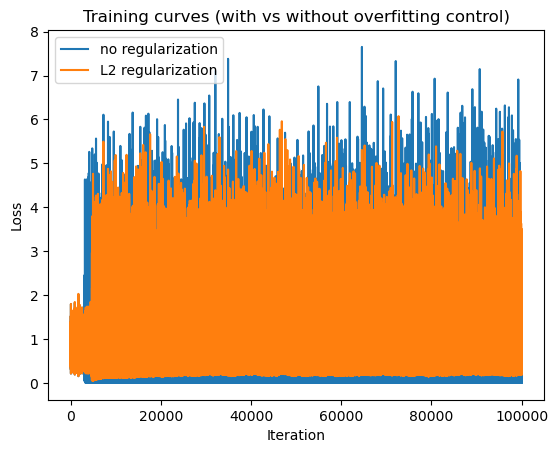

In [12]:
plt.plot(model_no_reg.loss_history, label="no regularization")
plt.plot(model_l2.loss_history, label="L2 regularization")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training curves (with vs without overfitting control)")
plt.legend()
plt.show()
